<a href="https://colab.research.google.com/github/SlavaBts/Distributions-of-distances-on-scRNA-embeddings/blob/main/Embedding_distances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача 8. Охарактеризуйте характеристическое распределение расстояний внутри разных типов клеток на разных эмбеддингах: на экспрессиях (только на высоко вариабельных генах, отшкалированных и лог-трансформированных), на PCA, на UMAP, и на Palantir.

# Загрузка и просмотр данных

In [ ]:
# Загружаем данные

!pip install scanpy[leiden]
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=T"

In [3]:
# Загружаем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scanpy.external as sce

sns.set_style("ticks") # стиль картинок
sc.set_figure_params(dpi=150)

In [4]:
# Прочитываем данные

adata = sc.read_h5ad("PBMC_Satija.h5ad")
adata.var_names_make_unique()

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'


In [6]:
# Смотрим метаданные
adata.obs

,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase
L1_AAACCCACATCAGTCA,P3_3,L1,P3,3,CD8 T,CD8 TEM,CD8 TEM_1,G1
L1_AAACCCATCCACACCT,P3_3,L1,P3,3,CD8 T,CD8 Naive,CD8 Naive,S
L1_AAACCCATCTGCGGAC,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S
L1_AAACCCATCTTAAGGC,P2_3,L1,P2,3,CD4 T,CD4 CTL,CD4 CTL,S
L1_AAACGAAAGATAACAC,P2_3,L1,P2,3,B,B naive,B naive kappa,S
...,...,...,...,...,...,...,...,...
L5_TTTGTTGGTACGATCT,P2_3,L5,P2,3,NK,NK,NK_2,G1
L5_TTTGTTGGTGGTCTGC,P1_0,L5,P1,0,Mono,CD14 Mono,CD14 Mono,G1
L5_TTTGTTGTCAACACCA,P2_3,L5,P2,3,Mono,CD14 Mono,CD14 Mono,G1
L5_TTTGTTGTCATGCATG,P2_3,L5,P2,3,CD8 T,CD8 Naive,CD8 Naive,G1


In [7]:
# Посмотрим размерность матрицы каунтов
adata.X

<17159x20729 sparse matrix of type '<class 'numpy.float32'>'
	with 30092825 stored elements in Compressed Sparse Row format>

In [8]:
# Посмотрим, какие доноры есть
print(adata.obs['donor'].unique())
print(adata.obs.groupby('donor').size())

['P3', 'P1', 'P2']
Categories (3, object): ['P1', 'P2', 'P3']
donor
P1    6443
P2    5714
P3    5002
dtype: int64


<ipython-input-8-b8e5f4e2eec8>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby('donor').size())


In [9]:
# Посмотрим, какие клеточные типы присутствуют
print(adata.obs['celltype.l1'].unique())

['CD8 T', 'CD4 T', 'B', 'NK', 'other T', 'Mono', 'DC', 'other']
Categories (8, object): ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']


In [10]:
# Отбираем конкретного донора
adata_P1 = adata[adata.obs['donor'] == 'P1'].copy()
print(adata_P1.obs['donor'].unique())
print(adata_P1.obs['donor'].count())

['P1']
Categories (1, object): ['P1']
6443


In [11]:
# Проверим еще раз во избежание невроза
adata_P1.X

<6443x20729 sparse matrix of type '<class 'numpy.float32'>'
	with 11674554 stored elements in Compressed Sparse Row format>

# QC

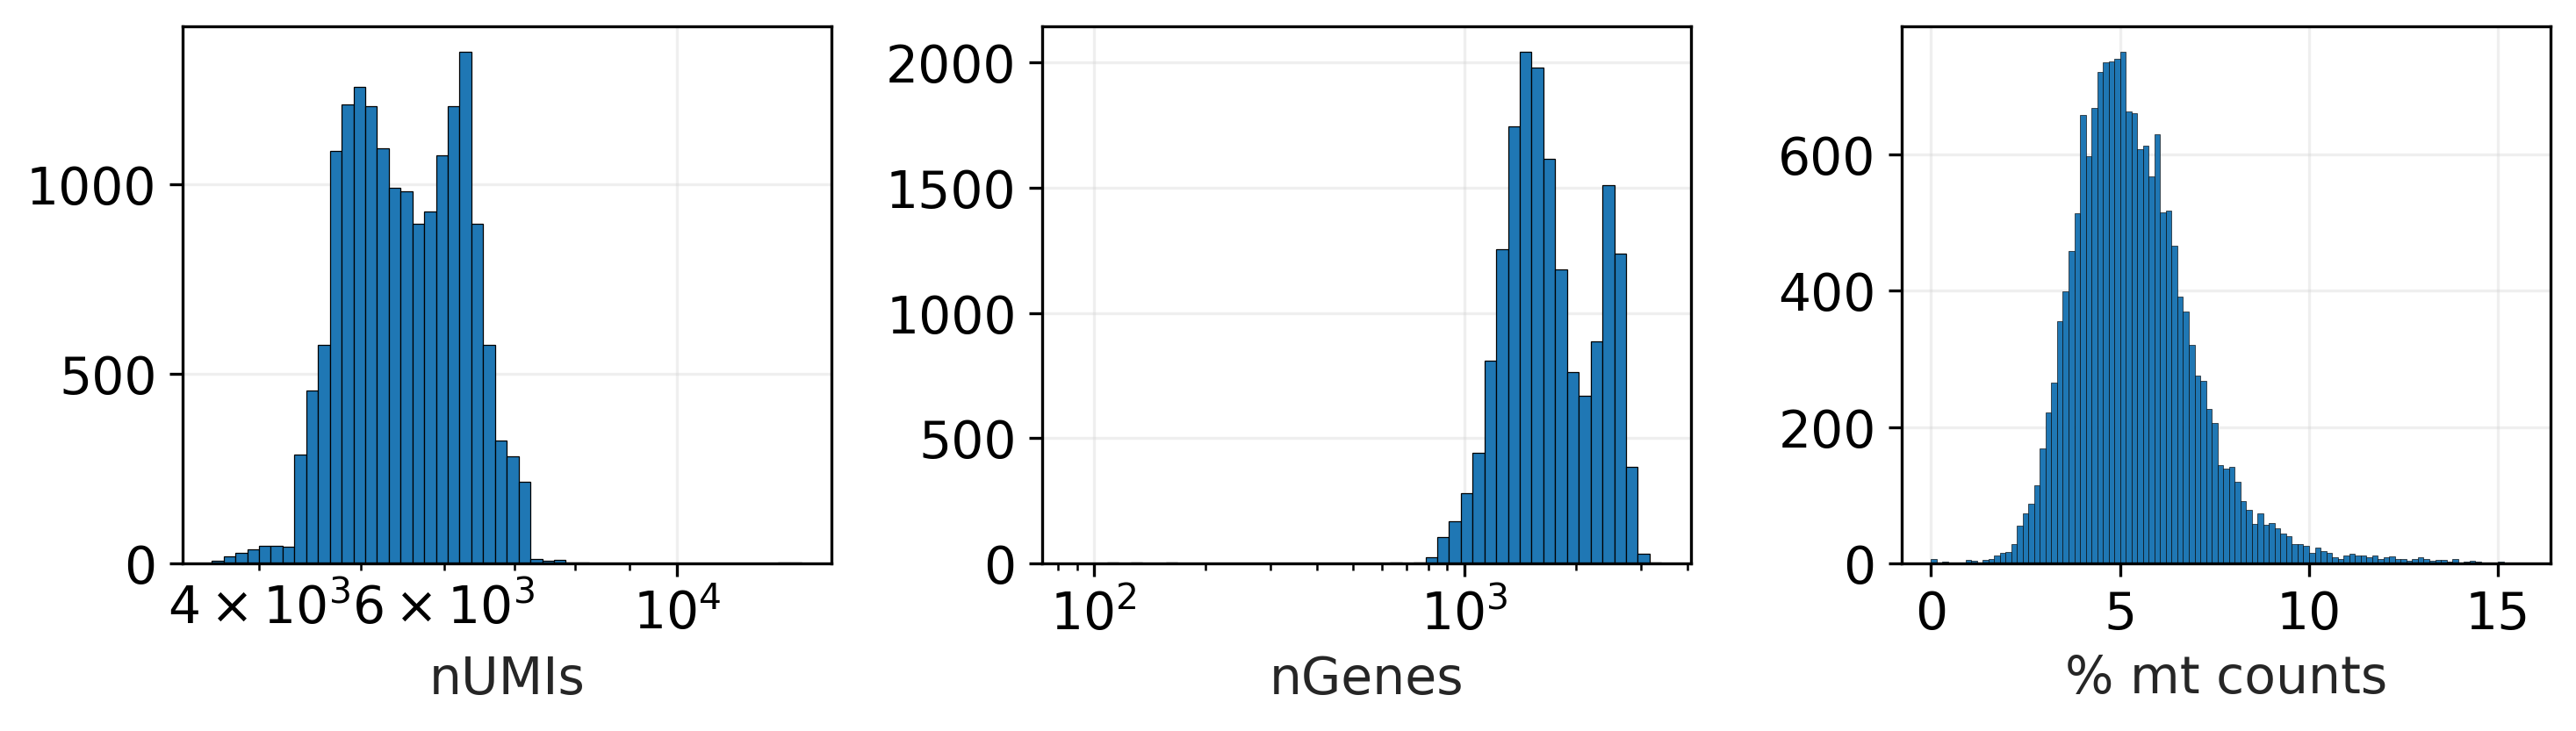

In [12]:
# Смотрим метрики QC для overall-датасета

adata.var["mt"] = adata.var.index.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)

fig, axes = plt.subplots(ncols=3, figsize=(10, 3))

sns.histplot(adata.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

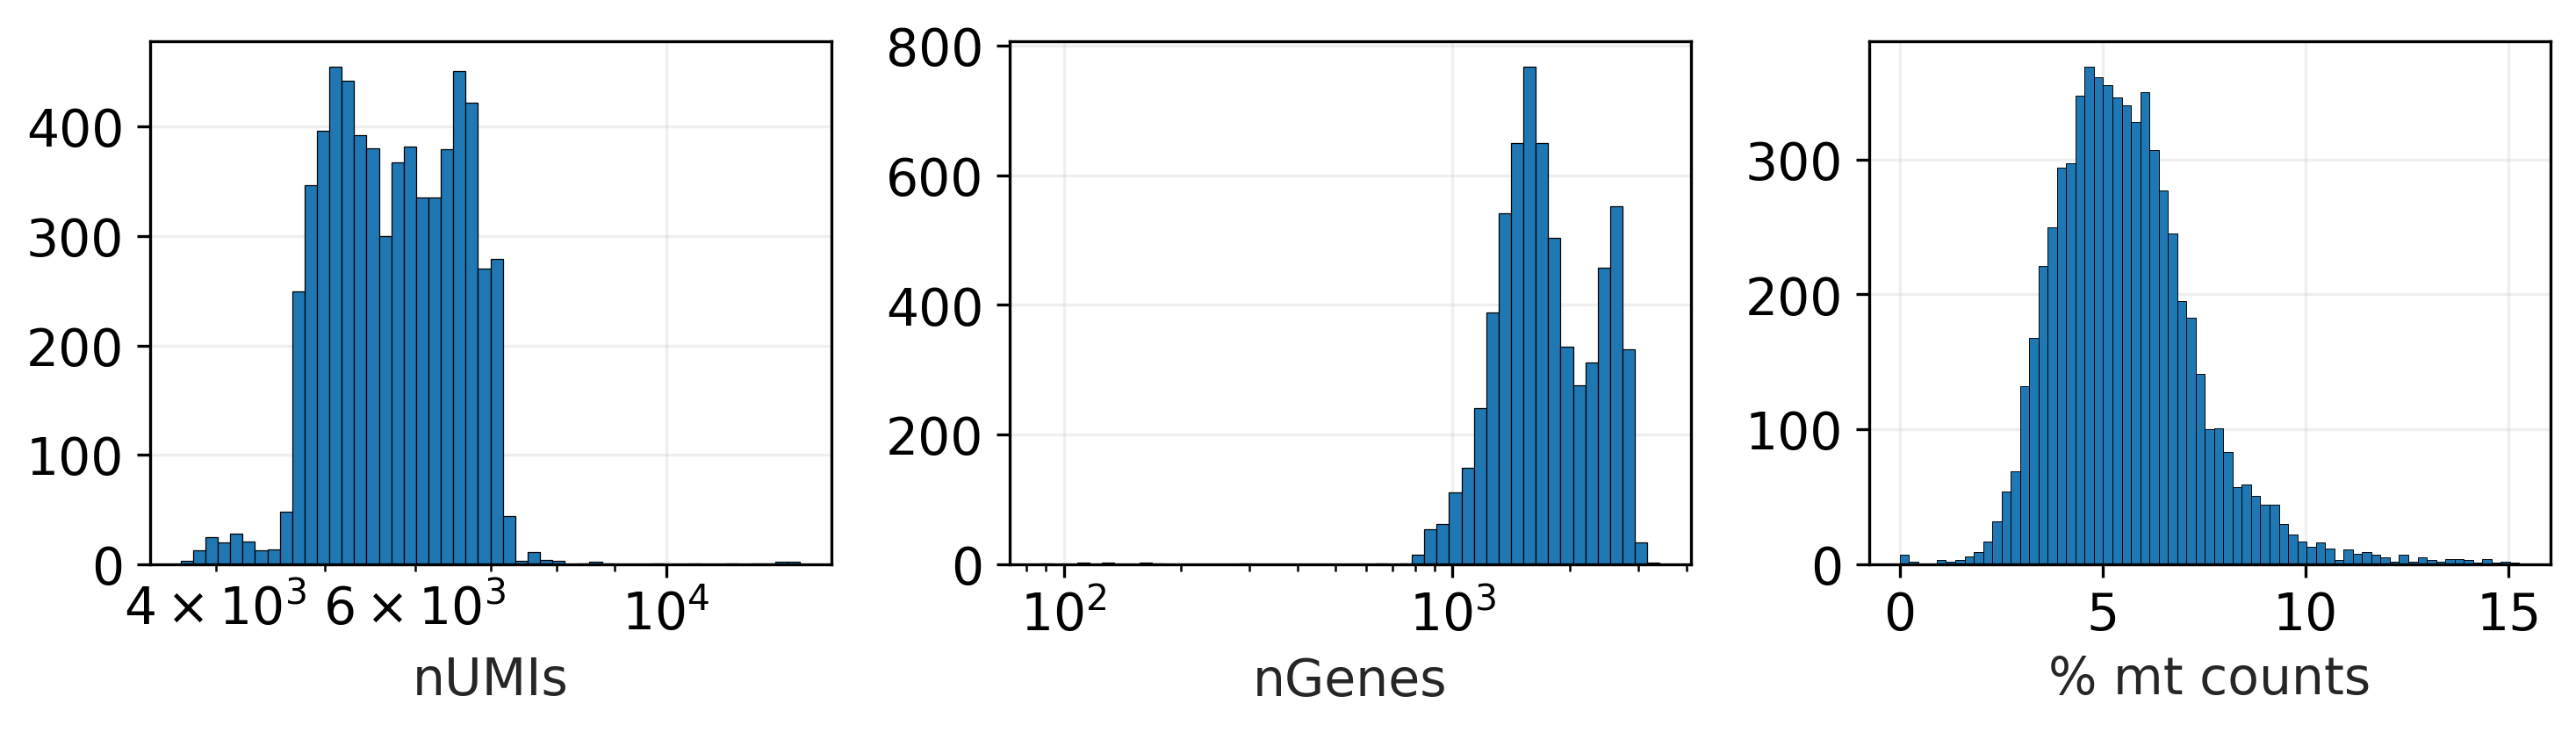

In [13]:
# Смотрим метрики QC для конкретного донора

adata_P1.var["mt"] = adata_P1.var.index.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata_P1,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)

fig, axes = plt.subplots(ncols=3, figsize=(10, 3))

sns.histplot(adata_P1.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_P1.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_P1.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

In [14]:
print(adata_P1)

AnnData object with n_obs × n_vars = 6443 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


# Процессинг

In [15]:
# Маркируем и удаляем дублеты

sc.pp.scrublet(adata_P1)
adata_P1 = adata_P1[adata_P1.obs.doublet_score <= 0.2].copy()

In [15]:
# Антиневроз
print(adata_P1)

AnnData object with n_obs × n_vars = 6392 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'


In [ ]:
# Нормализуем данные. Начиная с этой ячейки adata_P1 содержит нормированныe HVG

sc.pp.normalize_total(adata_P1, target_sum=1e4)
sc.pp.log1p(adata_P1)
sc.pp.highly_variable_genes(adata_P1, n_top_genes=3000)

adata_P1_raw = adata_P1.copy()

adata_P1 = adata_P1[:, adata_P1.var.highly_variable]

# Шкалирование, PCA, UMAP и Palantir

In [ ]:
# Шкалирование
sc.pp.scale(adata_P1, max_value=10)

computing PCA
    with n_comps=30
    finished (0:00:02)


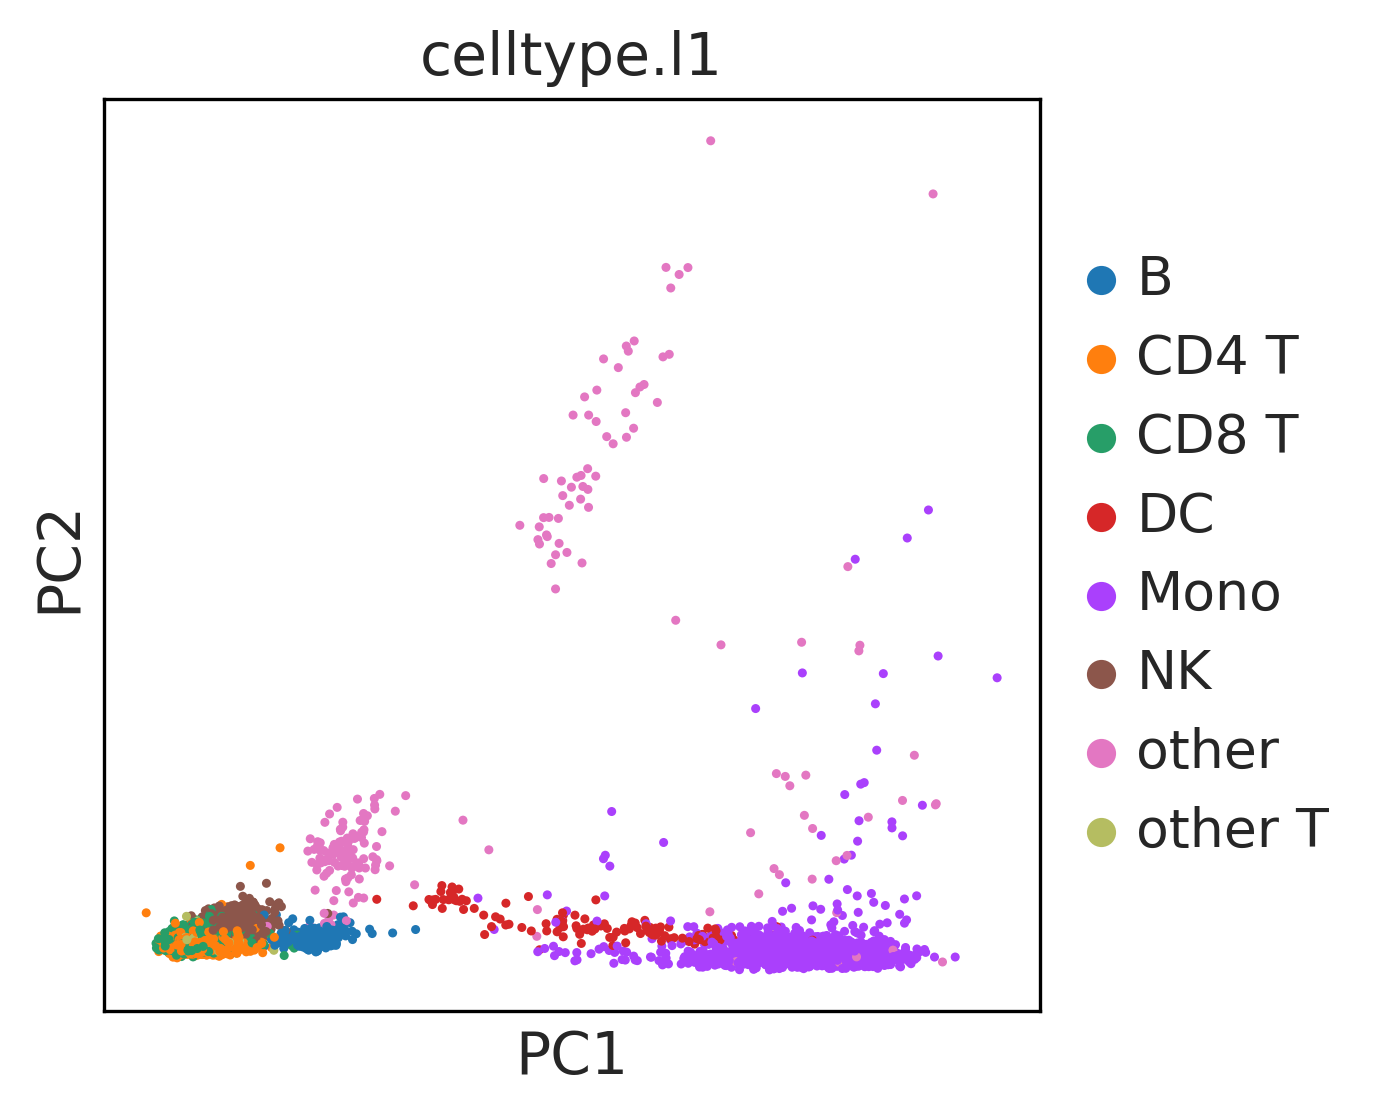

In [21]:
# PCA
sc.pp.pca(adata_P1, n_comps=30)
sc.pl.pca(adata_P1, color='celltype.l1')  # Визуализация PCA

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)


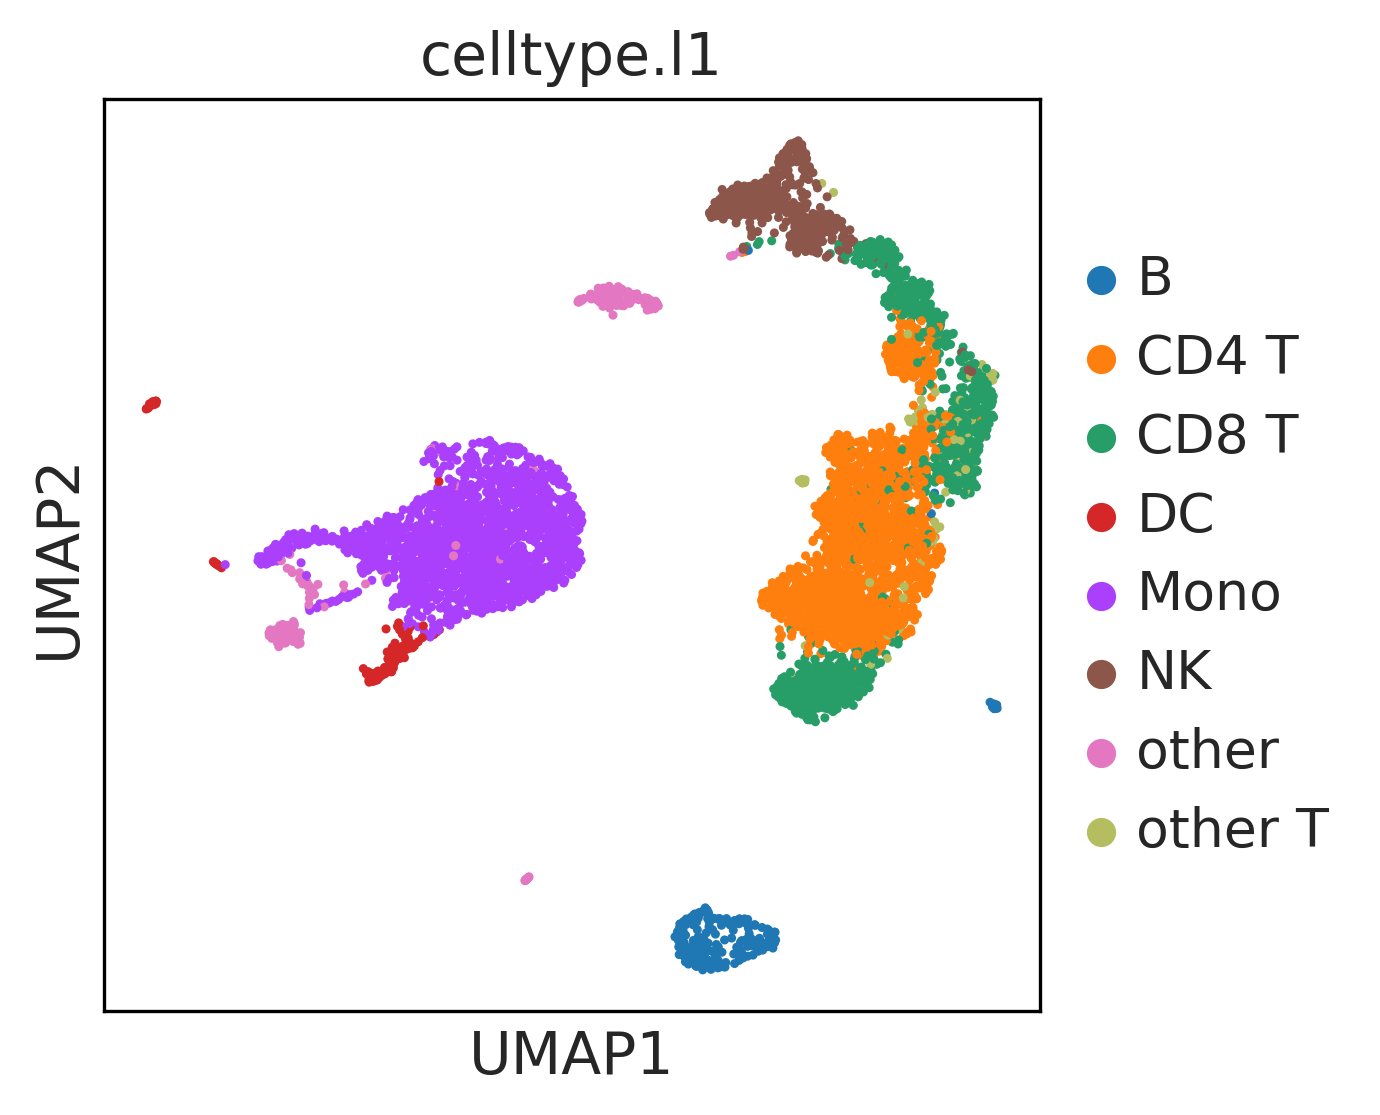

In [22]:
# UMAP
sc.pp.neighbors(adata_P1)  # Строим граф k-NN
sc.tl.umap(adata_P1)       # UMAP
sc.pl.umap(adata_P1, color='celltype.l1')  # Визуализация UMAP

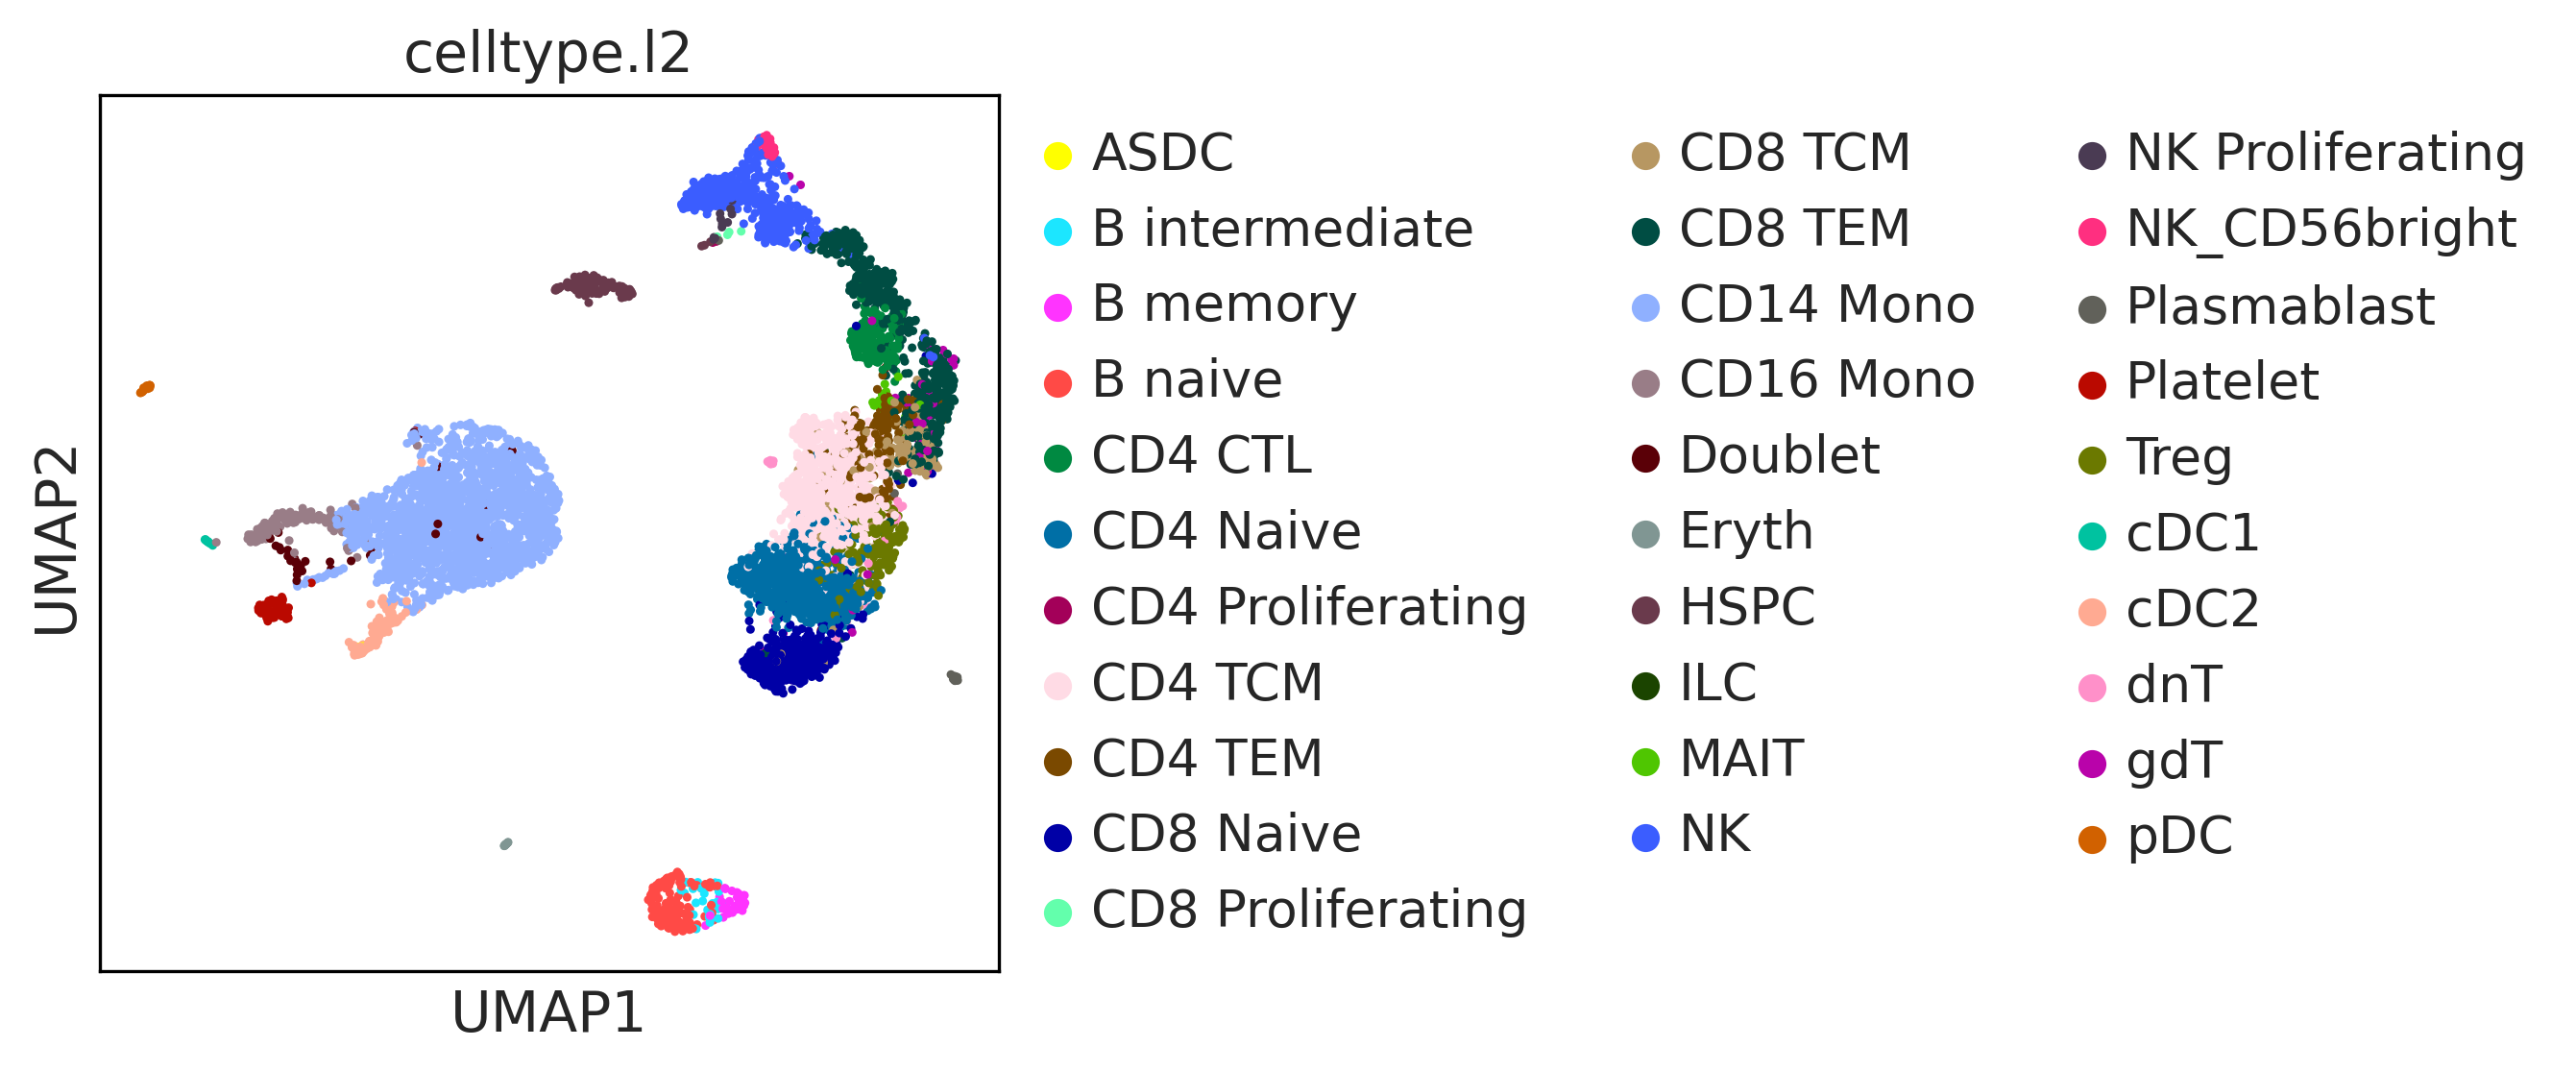

In [23]:
sc.pl.umap(adata_P1, color='celltype.l2')

In [ ]:
# Устанавливаем Palantir
pip install palantir
import palantir

In [ ]:
# 1. Извлечение PCA-координат из adata
pca_projections = pd.DataFrame(adata_P1.obsm["X_pca"], index=adata_P1.obs_names)

# 2. Построение диффузионных карт с помощью Palantir
# dm_res содержит собственные векторы и собственные значения диффузионных карт
dm_res = palantir.utils.run_diffusion_maps(pca_projections)

# 3. Определение многомасштабного пространства (multiscale space)
# Мы выбираем первые n_eigs собственных векторов для представления
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=4)

# 4. Сохранение результатов Palantir в obsm объекта AnnData
# Преобразуем ms_data в формат NumPy и добавляем его в AnnData
adata_P1.obsm["X_palantir"] = ms_data.values

# Пространство Z-статистик

In [47]:
from scipy.spatial.distance import pdist, squareform

# Вычисляем попарные расстояния (Евклидовы)
distances_exp_total = pdist(adata_P1.X, metric='euclidean')  # Возвращает массив расстояний

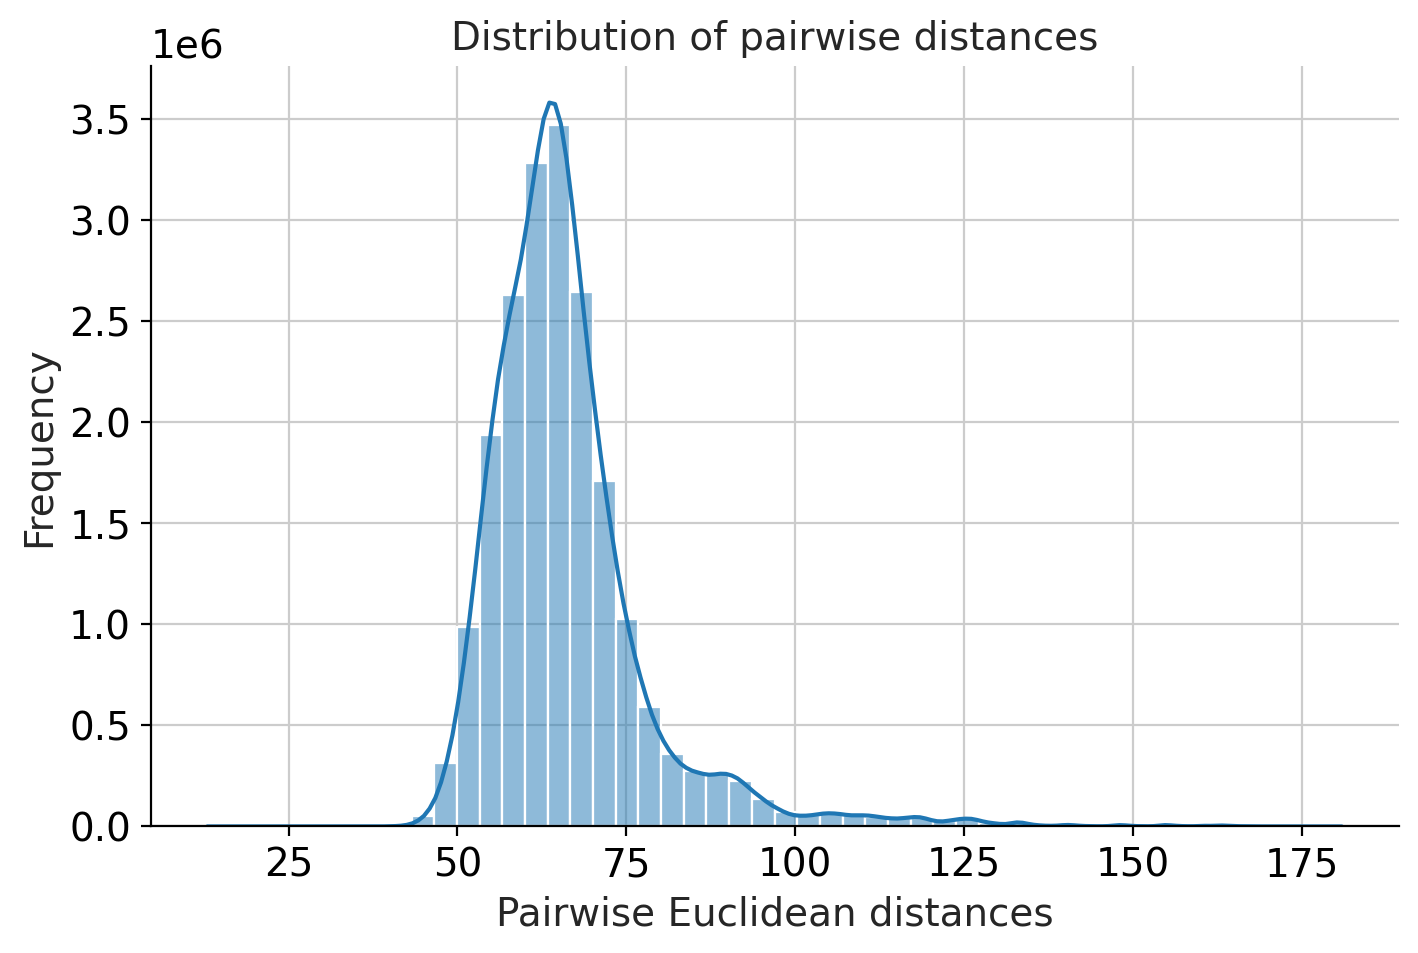

In [53]:
# Построение распределения расстояний
plt.figure(figsize=(8, 5))
sns.histplot(distances_exp_total, bins=50, kde=True)
plt.xlabel("Pairwise Euclidean distances")
plt.ylabel("Frequency")
plt.title("Distribution of pairwise distances")
plt.show()

In [33]:
# Словарь для хранения расстояний по типам клеток
distance_distribution_exp_intracell = {}

# Получаем уникальные типы клеток
cell_types = adata_P1.obs['celltype.l1'].unique()

# Итерируемся по каждому типу клеток
for cell_type in cell_types:
    # Отбираем данные для текущего типа клетки
    subset = adata_P1[adata_P1.obs['celltype.l1'] == cell_type]

    # Вычисляем попарные расстояния (Euclidean)
    distances_exp_intracell = pdist(subset.X, metric='euclidean')

    # Сохраняем расстояния в словарь
    distance_distribution_exp_intracell[cell_type] = distances_exp_intracell

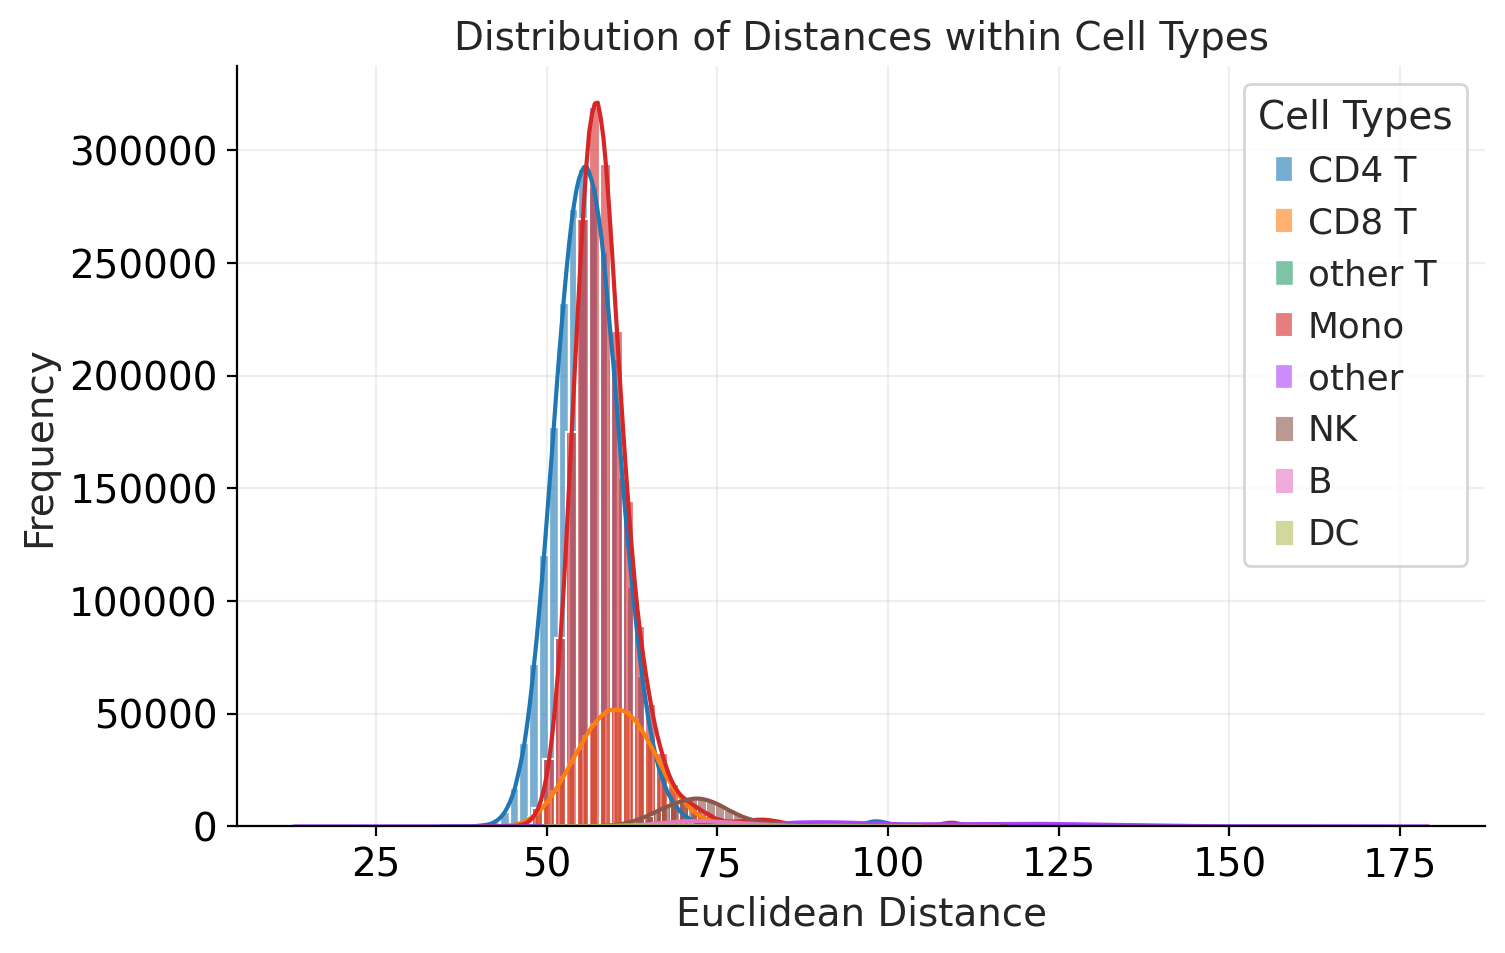

In [52]:
# Визуализация распределений
plt.figure(figsize=(8, 5))
for cell_type, distances_exp_intracell in distance_distribution_exp_intracell.items():
    sns.histplot(distances_exp_intracell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Distances within Cell Types")
plt.grid(alpha=0.3)
plt.show()

In [44]:
from scipy.spatial.distance import cdist

In [50]:
# Словарь для хранения межклеточных расстояний
distance_distribution_exp_intercell = {}

# Получаем уникальные типы клеток
cell_types = adata_P1.obs['celltype.l1'].unique()

# Итерируемся по каждому типу клеток
for cell_type in cell_types:
    # Отбираем данные для текущего типа клетки (X) и всех остальных типов (не-X)
    subset_X = adata_P1[adata_P1.obs['celltype.l1'] == cell_type]
    subset_not_X = adata_P1[adata_P1.obs['celltype.l1'] != cell_type]

    # Вычисляем попарные расстояния между X и не-X (Euclidean)
    distances_exp_intercell = cdist(subset_X.X, subset_not_X.X, metric='euclidean')

    # Сохраняем расстояния в словарь
    distance_distribution_exp_intercell[cell_type] = distances_exp_intercell.flatten()

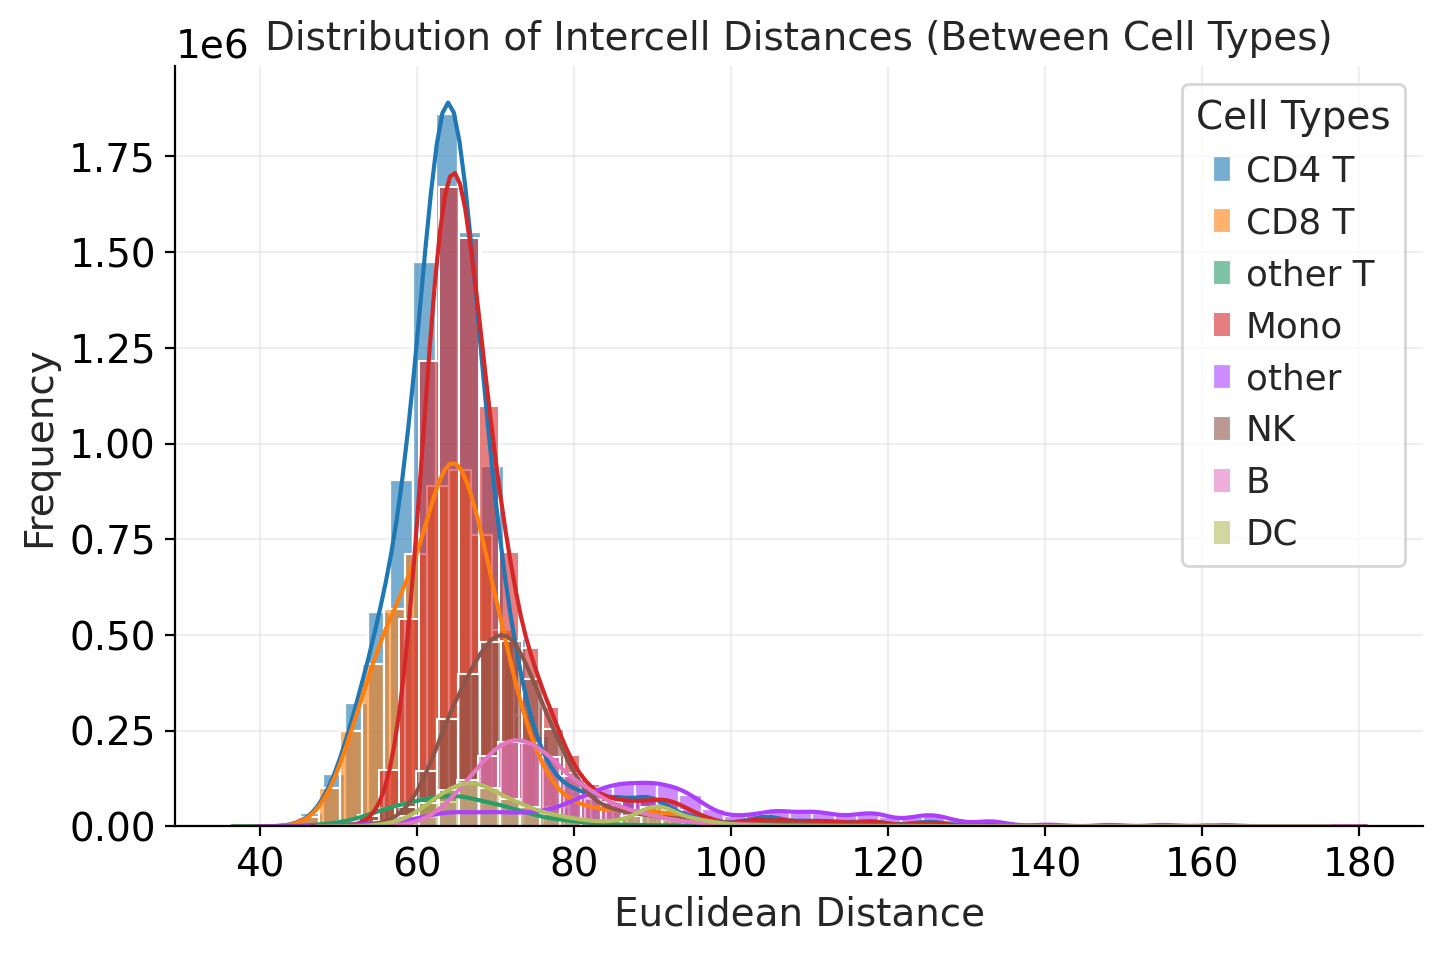

In [51]:
# Визуализация распределений
plt.figure(figsize=(8, 5))
for cell_type, distances_exp_intercell in distance_distribution_exp_intercell.items():
    sns.histplot(distances_exp_intercell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Intercell Distances (Between Cell Types)")
plt.grid(alpha=0.3)
plt.show()

# PCA-пространство

In [54]:
# Координаты клеток в PCA-пространстве
pca_coords = adata_P1.obsm['X_pca']

# Вычисление попарных расстояний (евклидовы)
distances_pca_total = pdist(pca_coords, metric='euclidean')

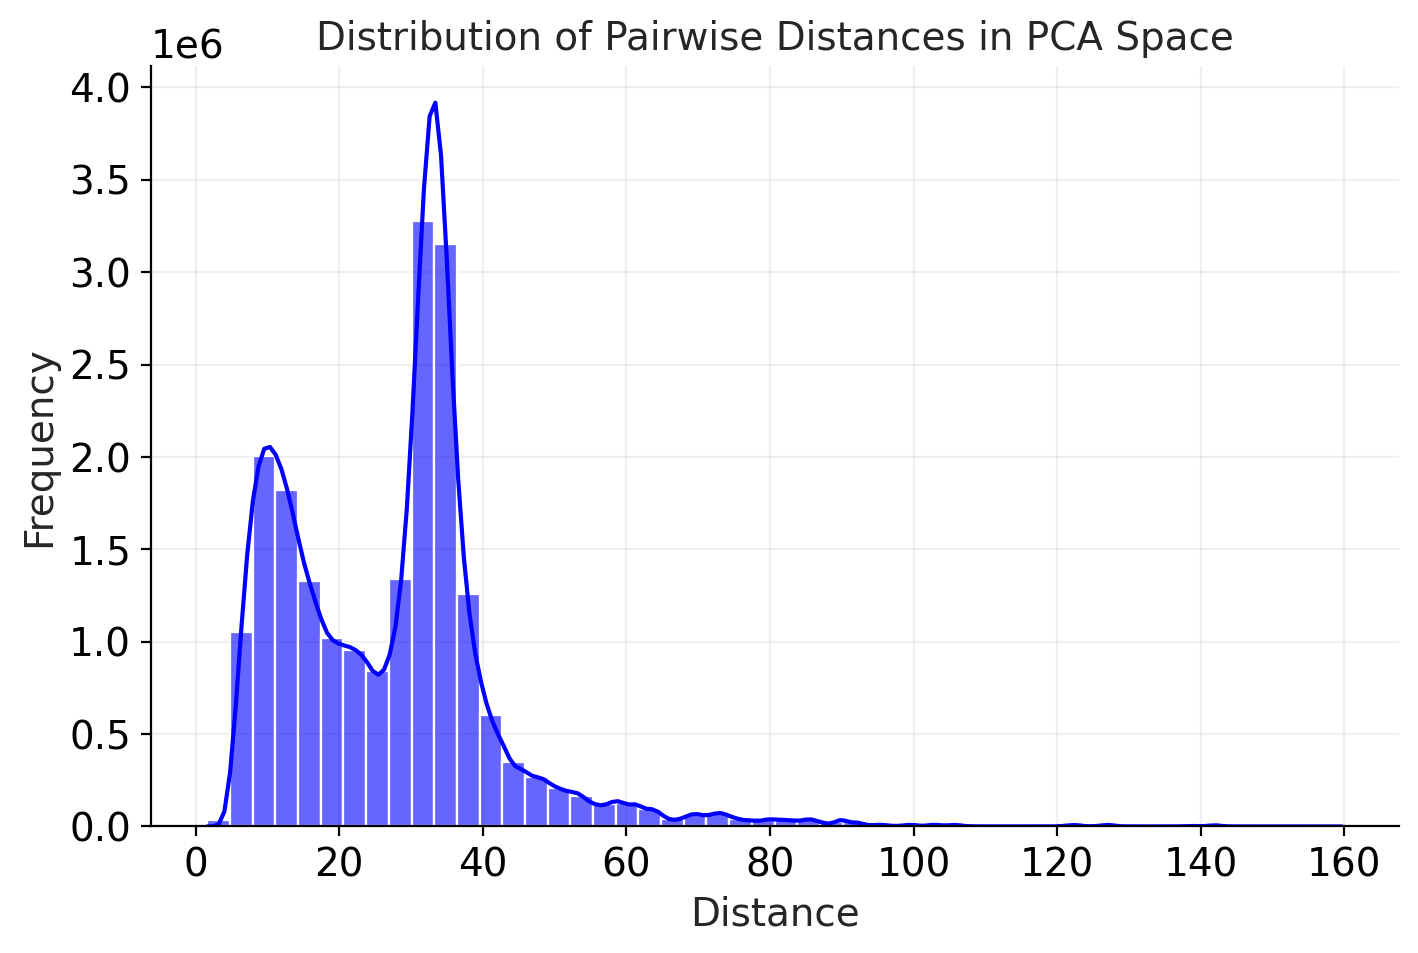

In [55]:
# Визуализация распределения расстояний
plt.figure(figsize=(8, 5))
sns.histplot(distances_pca_total, bins=50, kde=True, color="blue", alpha=0.6)
plt.title("Distribution of Pairwise Distances in PCA Space")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [31]:
# Словарь для хранения расстояний по типам клеток
distance_distributions_pca_intracell = {}

# Уникальные клеточные типы
cell_types = adata_P1.obs['celltype.l1'].unique()

# Вычисление расстояний для каждого клеточного типа
for cell_type in cell_types:
    # Подмножество клеток данного типа
    subset = adata_P1[adata_P1.obs['celltype.l1'] == cell_type]

    # Координаты клеток в PCA-пространстве
    subset_pca_coords = subset.obsm['X_pca']

    # Попарные расстояния
    distances_pca_intracell = pdist(subset_pca_coords, metric='euclidean')

    # Сохранение результатов
    distance_distributions_pca_intracell[cell_type] = distances_pca_intracell

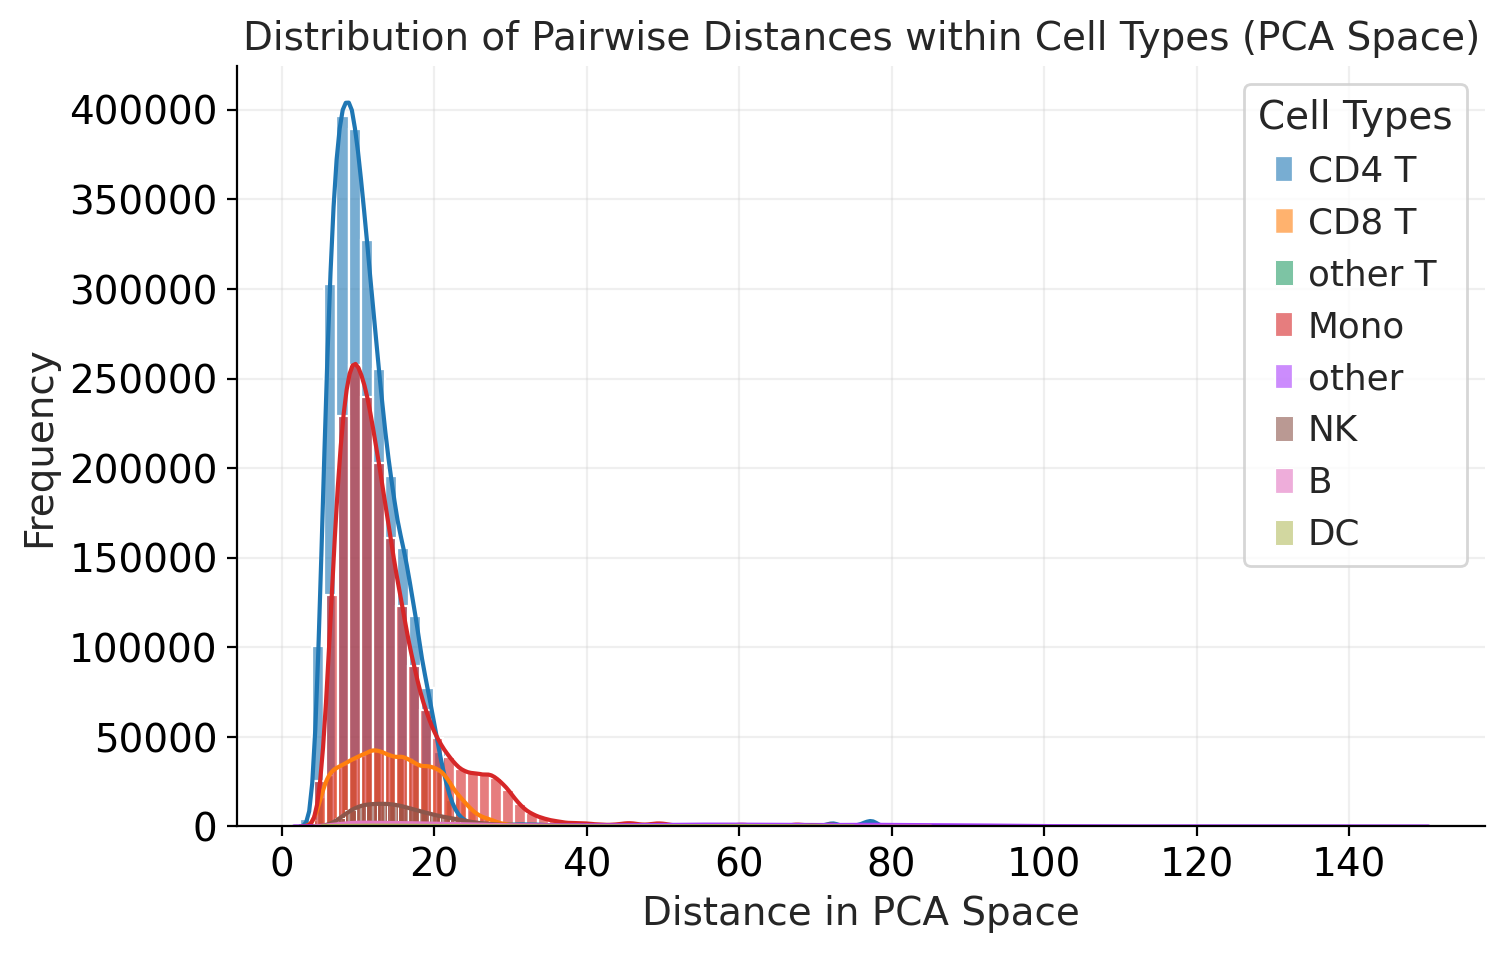

In [56]:
# Визуализация распределений
plt.figure(figsize=(8, 5))
for cell_type, distances_pca_intracell in distance_distributions_pca_intracell.items():
    sns.histplot(distances_pca_intracell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Distance in PCA Space")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances within Cell Types (PCA Space)")
plt.grid(alpha=0.3)
plt.show()

In [64]:
# Словарь для хранения межклеточных расстояний
intercell_distances_pca = {}

# Уникальные типы клеток
cell_types = adata_P1.obs['celltype.l1'].unique()

# Вычисление межклеточных расстояний для каждого клеточного типа
for cell_type in cell_types:
    # Подмножество клеток данного типа
    subset_X = adata_P1[adata_P1.obs['celltype.l1'] == cell_type]

    # Подмножество клеток остальных типов
    subset_not_X = adata_P1[adata_P1.obs['celltype.l1'] != cell_type]

    # Координаты клеток в PCA-пространстве
    subset_pca_coords_X = subset_X.obsm['X_pca']
    subset_pca_coords_not_X = subset_not_X.obsm['X_pca']

    # Попарные расстояния между клетками текущего типа и всех остальных типов
    distances_pca_intercell = cdist(subset_pca_coords_X, subset_pca_coords_not_X, metric='euclidean')

    # Сохраняем расстояния (в плоский список)
    intercell_distances_pca[cell_type] = distances_pca_intercell.flatten()

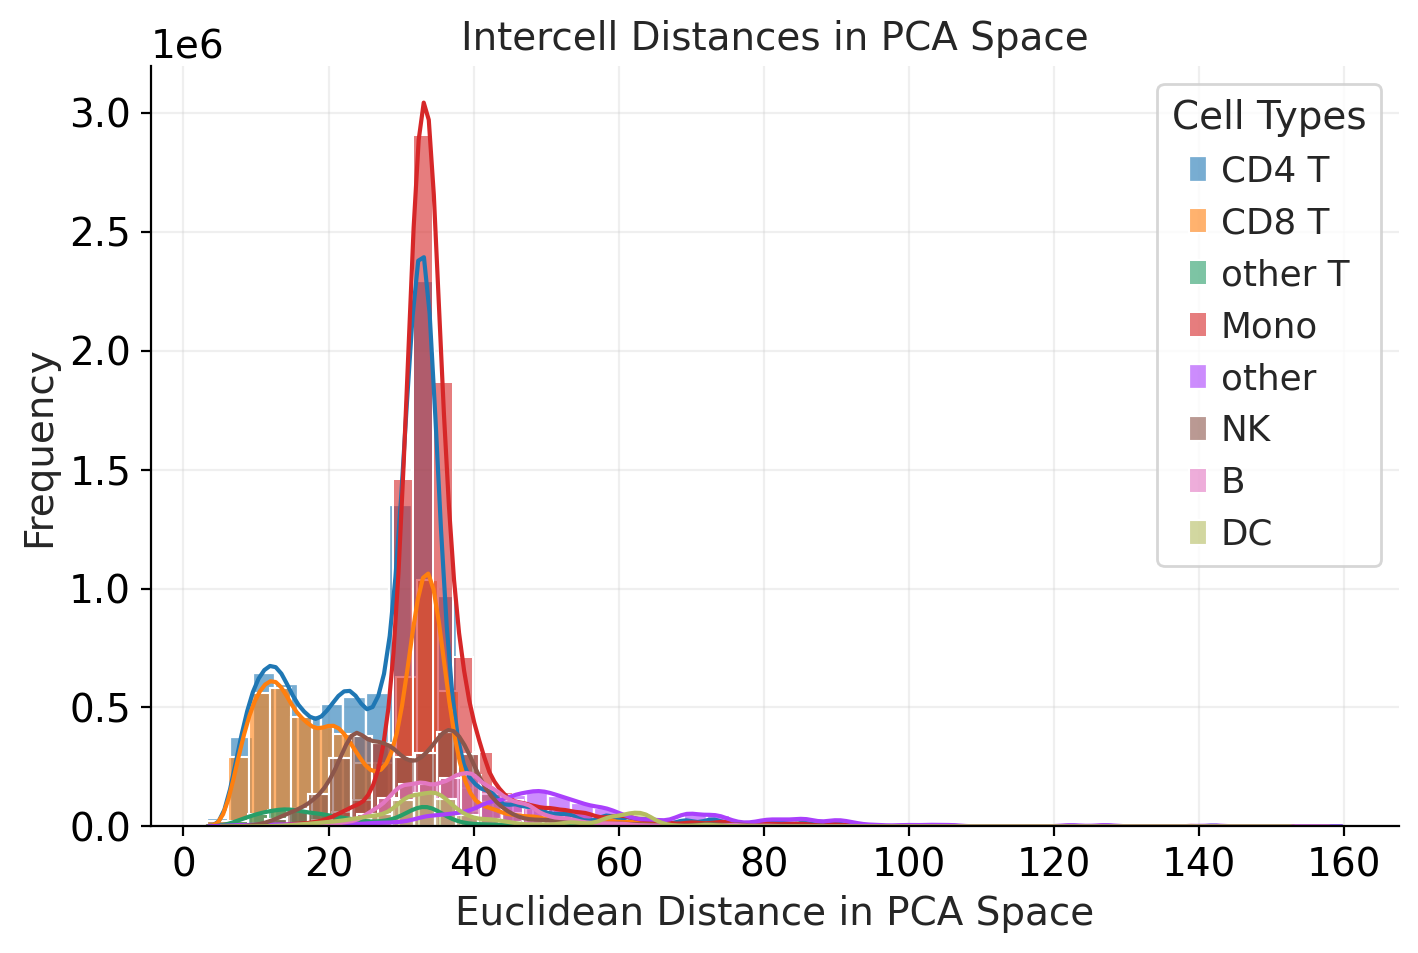

In [65]:
plt.figure(figsize=(8, 5))
for cell_type, distances_pca_intercell in intercell_distances_pca.items():
    sns.histplot(distances_pca_intercell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Euclidean Distance in PCA Space")
plt.ylabel("Frequency")
plt.title("Intercell Distances in PCA Space")
plt.grid(alpha=0.3)
plt.show()

# UMAP-пространство

In [57]:
# Извлекаем координаты UMAP
umap_coordinates = adata_P1.obsm['X_umap']

# Вычисляем попарные расстояния
distances_umap_total = pdist(umap_coordinates, metric='euclidean')

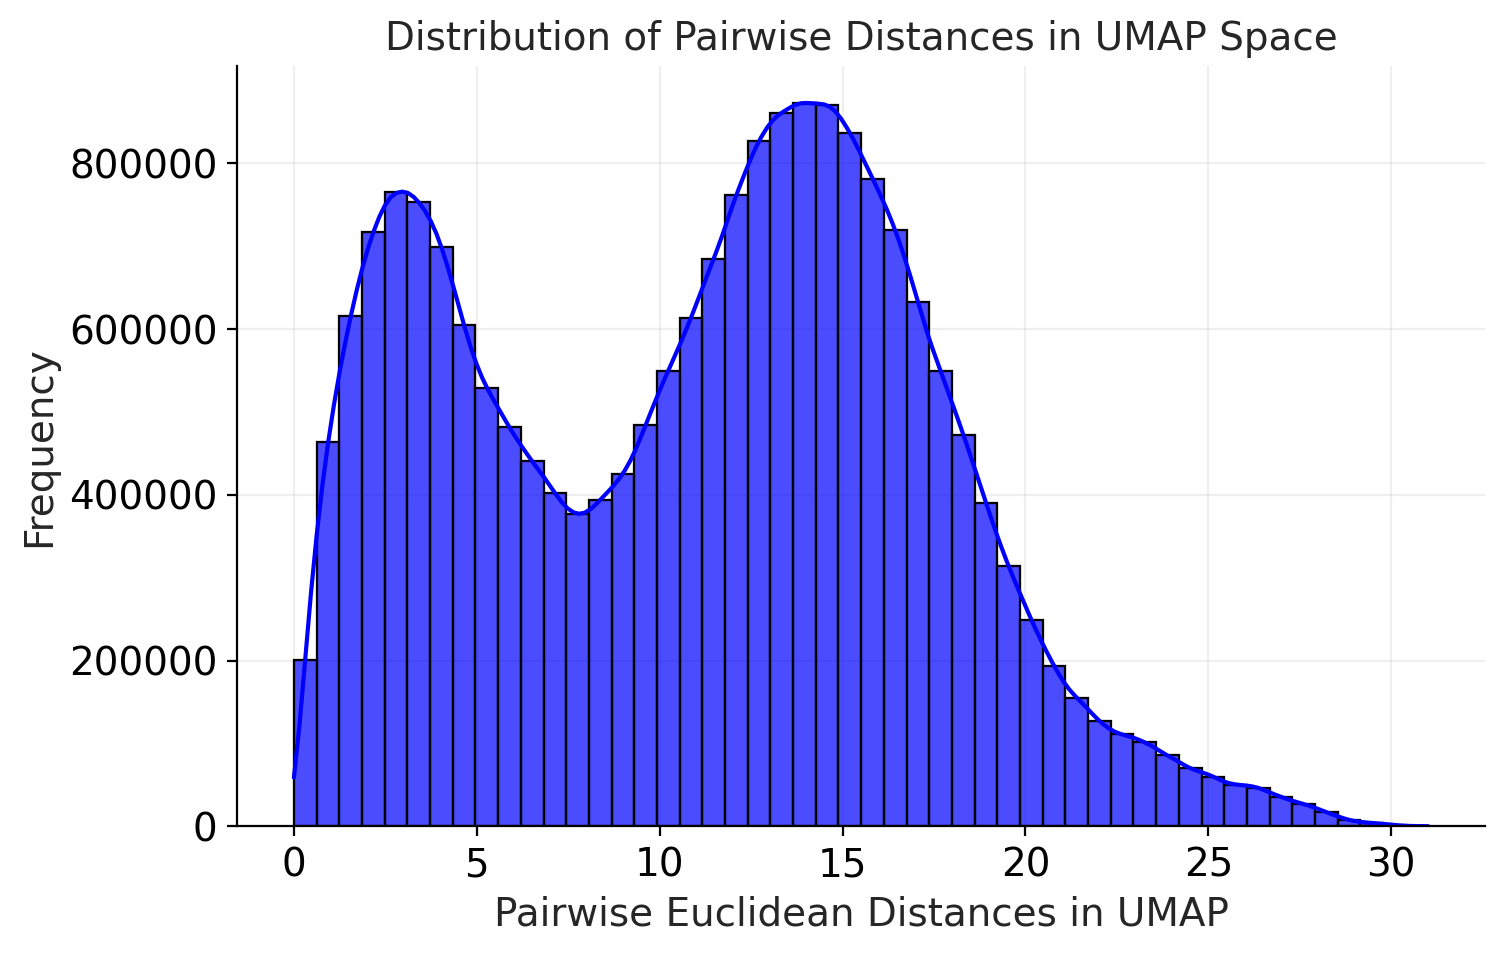

In [58]:
# Построение гистограммы распределения расстояний
plt.figure(figsize=(8, 5))
sns.histplot(distances_umap_total, bins=50, kde=True, color='blue', alpha=0.7, edgecolor="black")
plt.xlabel("Pairwise Euclidean Distances in UMAP")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances in UMAP Space")
plt.grid(alpha=0.3)
plt.show()

In [59]:
# Словарь для хранения расстояний по типам клеток
distance_distributions_umap_intracell = {}

# Уникальные клеточные типы
cell_types = adata_P1.obs['celltype.l1'].unique()

# Вычисление расстояний для каждого клеточного типа
for cell_type in cell_types:
    subset = adata_P1[adata_P1.obs['celltype.l1'] == cell_type] # Подмножество клеток данного типа

    subset_umap_coords = subset.obsm['X_umap'] # Координаты клеток в UMAP-пространстве

    distances_umap_intracell = pdist(subset_umap_coords, metric='euclidean') # Попарные расстояния

    distance_distributions_umap_intracell[cell_type] = distances_umap_intracell # Сохранение результатов

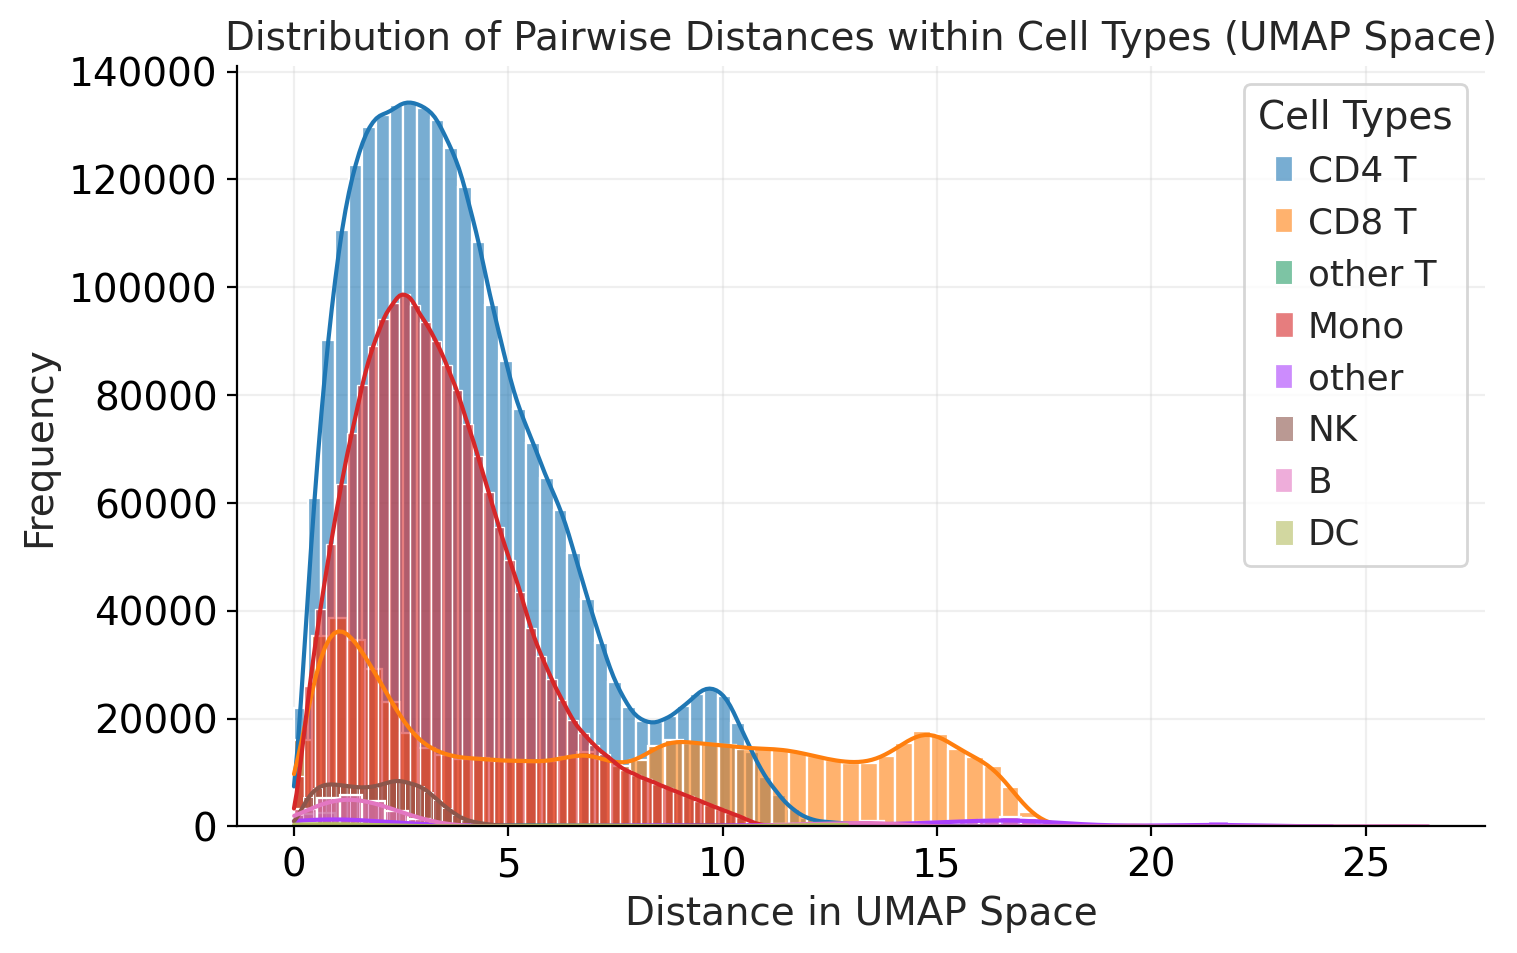

In [60]:
# Визуализация распределений
plt.figure(figsize=(8, 5))
for cell_type, distances_umap_intracell in distance_distributions_umap_intracell.items():
    sns.histplot(distances_umap_intracell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Distance in UMAP Space")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances within Cell Types (UMAP Space)")
plt.grid(alpha=0.3)
plt.show()

In [66]:
# Словарь для хранения межклеточных расстояний
intercell_distances_umap = {}

# Уникальные типы клеток
cell_types = adata_P1.obs['celltype.l1'].unique()

# Вычисление межклеточных расстояний для каждого клеточного типа
for cell_type in cell_types:
    # Подмножество клеток данного типа
    subset_X = adata_P1[adata_P1.obs['celltype.l1'] == cell_type]

    # Подмножество клеток остальных типов
    subset_not_X = adata_P1[adata_P1.obs['celltype.l1'] != cell_type]

    # Координаты клеток в UMAP-пространстве
    subset_umap_coords_X = subset_X.obsm['X_umap']
    subset_umap_coords_not_X = subset_not_X.obsm['X_umap']

    # Попарные расстояния между клетками текущего типа и всех остальных типов
    distances_umap_intercell = cdist(subset_umap_coords_X, subset_umap_coords_not_X, metric='euclidean')

    # Сохраняем расстояния
    intercell_distances_umap[cell_type] = distances_umap_intercell.flatten()

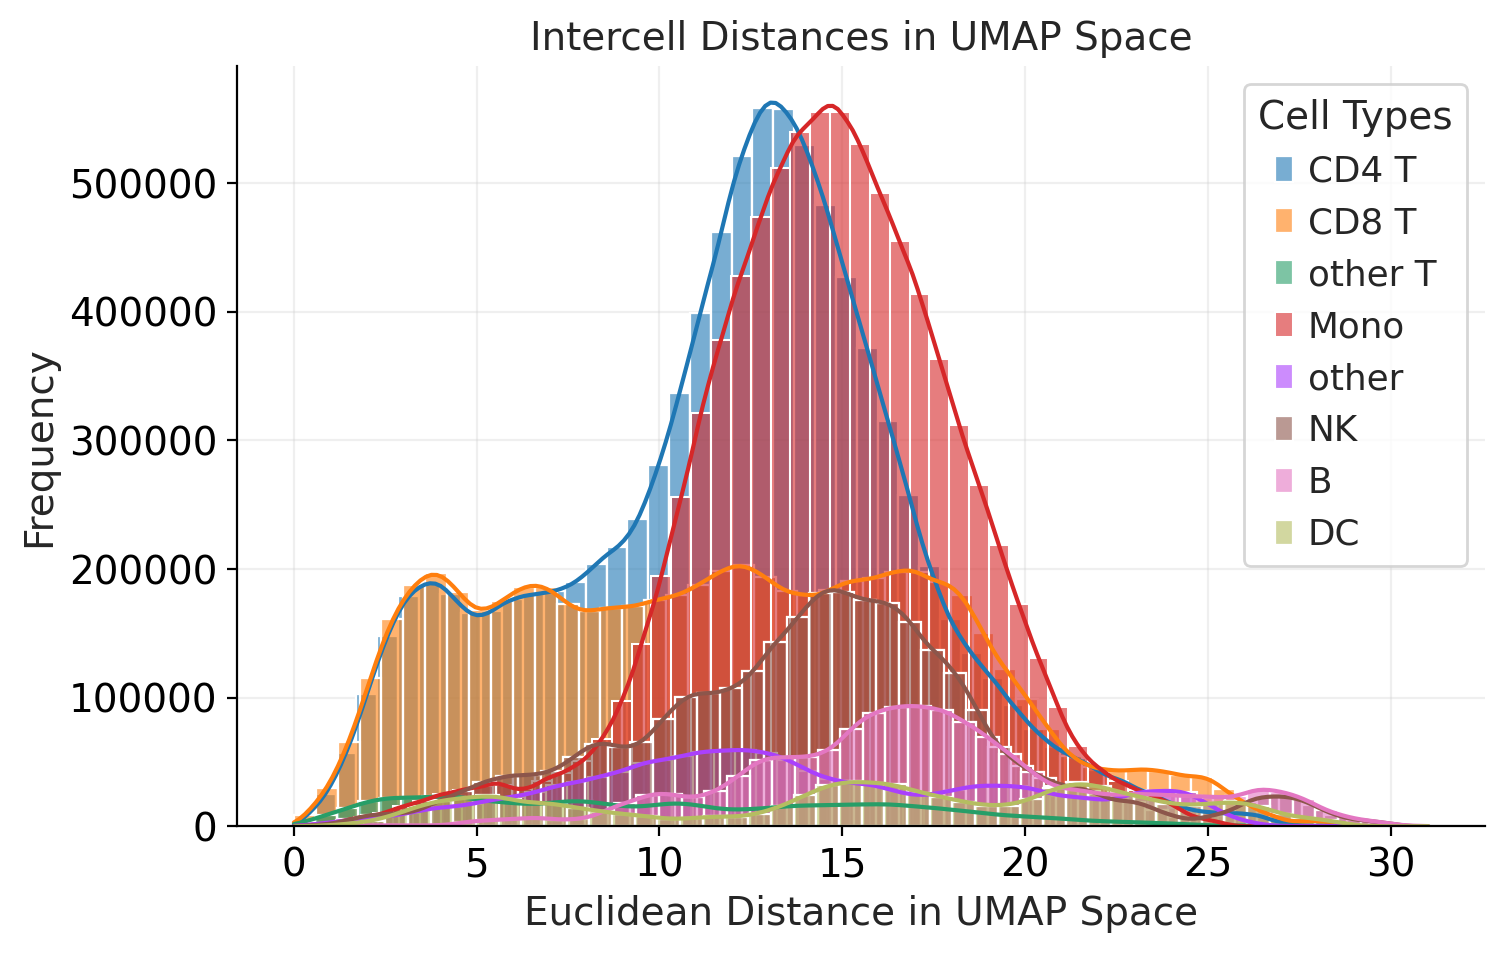

In [67]:
plt.figure(figsize=(8, 5))
for cell_type, distances_umap_intercell in intercell_distances_umap.items():
    sns.histplot(distances_umap_intercell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Euclidean Distance in UMAP Space")
plt.ylabel("Frequency")
plt.title("Intercell Distances in UMAP Space")
plt.grid(alpha=0.3)
plt.show()

# Palantir-пространство

In [62]:
# Извлекаем Palantir координаты
palantir_coords = adata_P1.obsm["X_palantir"]

# Вычисляем попарные расстояния
distances_palantir_total = pdist(palantir_coords, metric='euclidean')

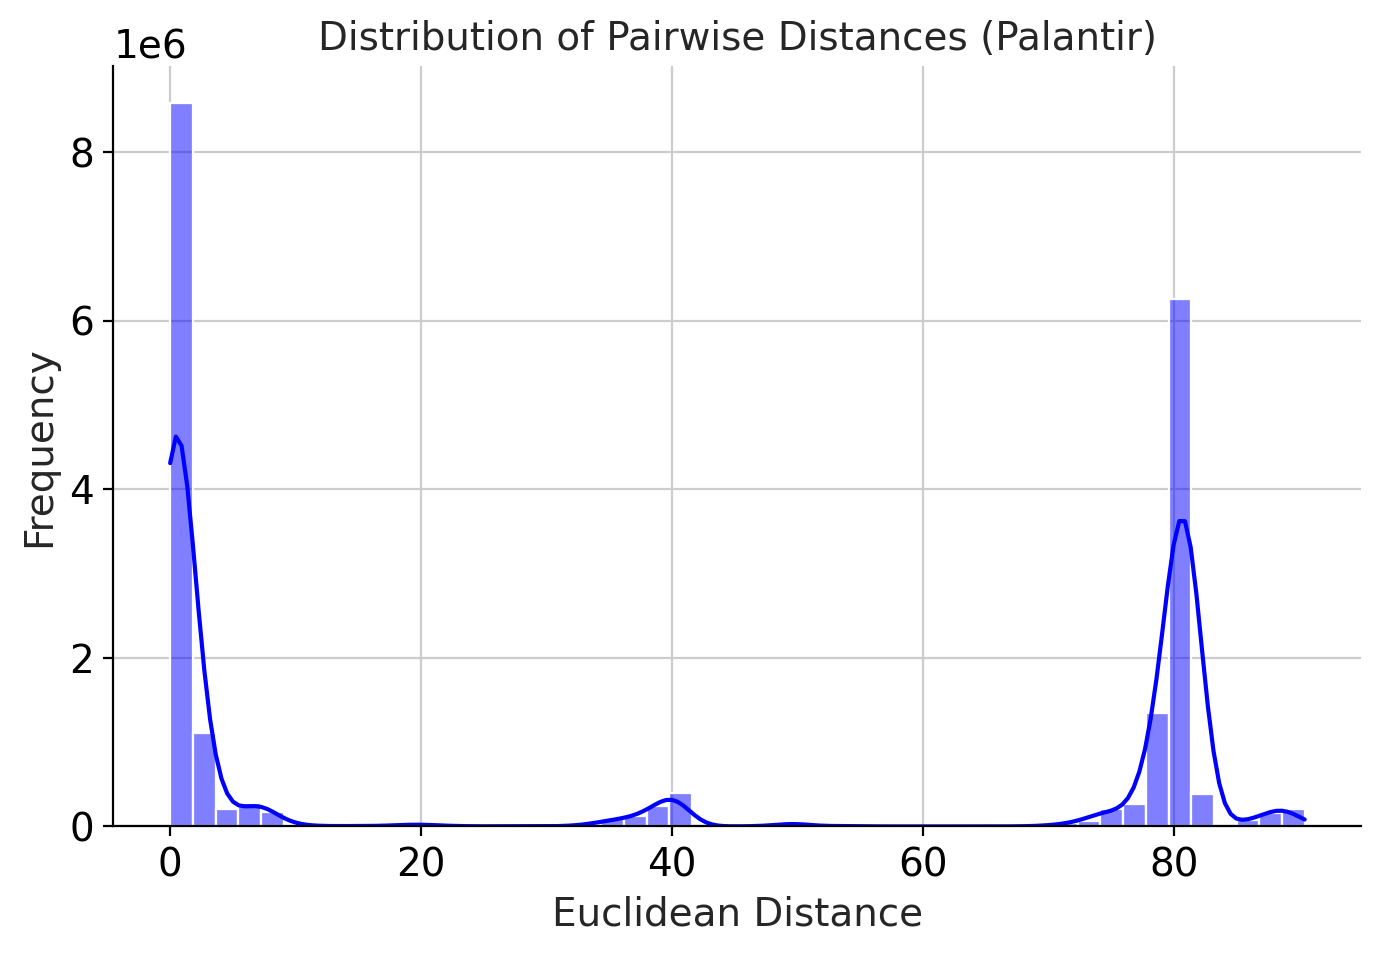

In [63]:
plt.figure(figsize=(8, 5))
sns.histplot(distances_palantir_total, bins=50, kde=True, color='blue')
plt.title("Distribution of Pairwise Distances (Palantir)")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.show()

In [68]:
# Словарь для хранения внутриклеточных расстояний
intracell_distances_palantir = {}

# Уникальные типы клеток
cell_types = adata_P1.obs['celltype.l1'].unique()

# Вычисление внутриклеточных расстояний для каждого клеточного типа
for cell_type in cell_types:
    # Подмножество клеток данного типа
    subset = adata_P1[adata_P1.obs['celltype.l1'] == cell_type]

    # Координаты клеток в Palantir-пространстве
    subset_palantir_coords = subset.obsm['X_palantir']

    # Попарные расстояния внутри клеток данного типа
    distances_palantir_intracell = pdist(subset_palantir_coords, metric='euclidean')

    # Сохраняем расстояния
    intracell_distances_palantir[cell_type] = distances_palantir_intracell

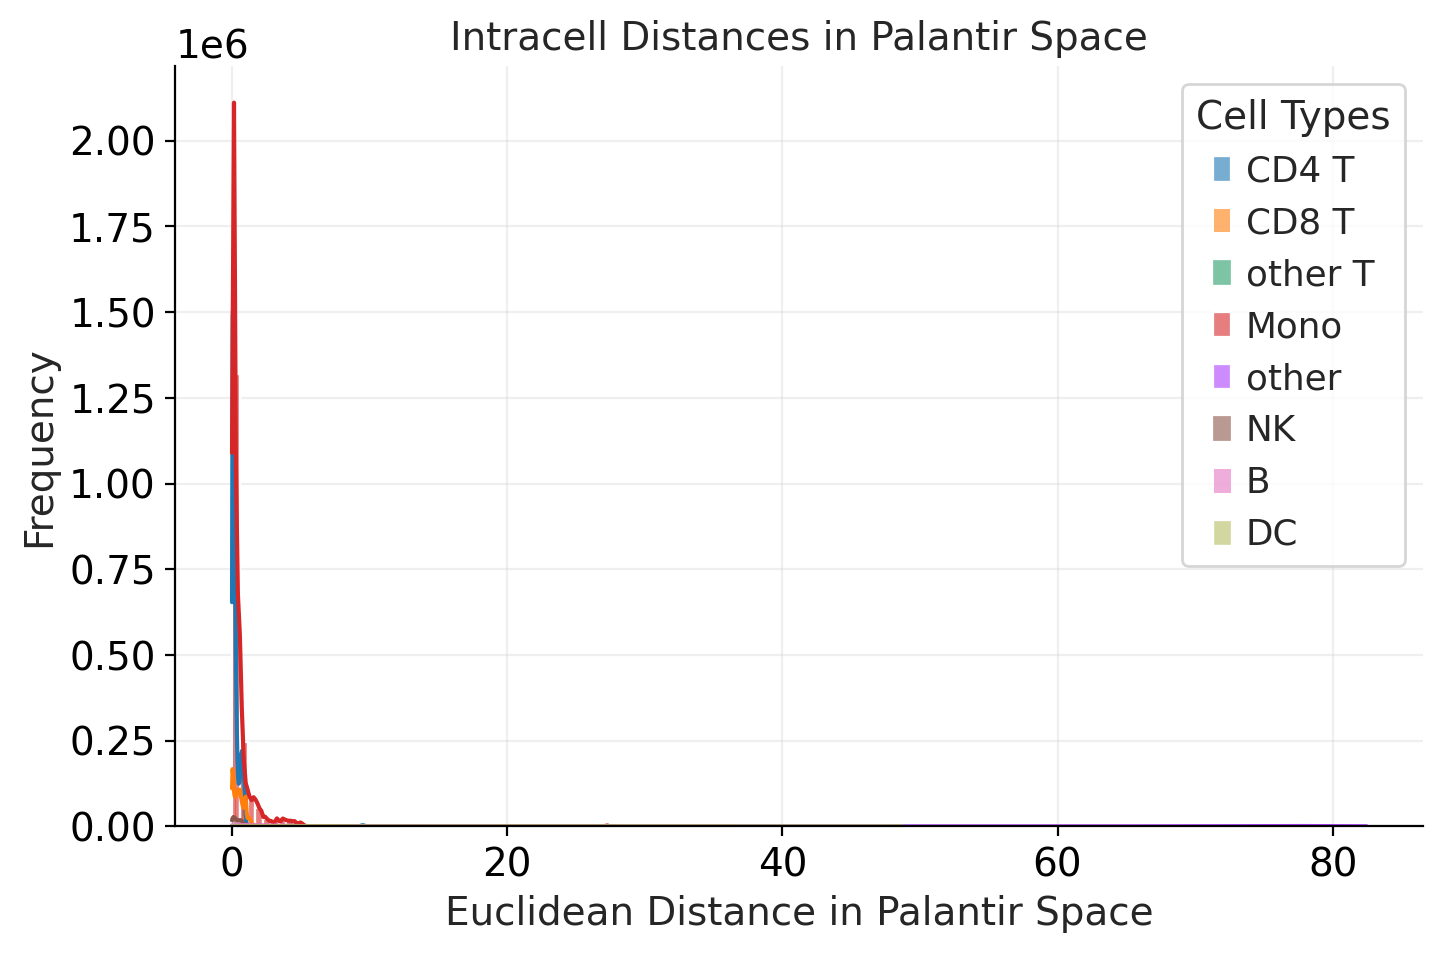

In [69]:
plt.figure(figsize=(8, 5))
for cell_type, distances_palantir_intracell in intracell_distances_palantir.items():
    sns.histplot(distances_palantir_intracell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Euclidean Distance in Palantir Space")
plt.ylabel("Frequency")
plt.title("Intracell Distances in Palantir Space")
plt.grid(alpha=0.3)
plt.show()

In [71]:
# Вычисление межклеточных расстояний для каждого клеточного типа
for cell_type in cell_types:
    # Подмножество клеток данного типа
    subset_X = adata_P1[adata_P1.obs['celltype.l1'] == cell_type]

    # Подмножество клеток остальных типов
    subset_not_X = adata_P1[adata_P1.obs['celltype.l1'] != cell_type]

    # Координаты клеток в Palantir-пространстве
    subset_palantir_coords_X = subset_X.obsm['X_palantir']
    subset_palantir_coords_not_X = subset_not_X.obsm['X_palantir']

    # Попарные расстояния между клетками текущего типа и всех остальных типов
    distances_palantir_intercell = cdist(subset_palantir_coords_X, subset_palantir_coords_not_X, metric='euclidean')

    # Сохраняем расстояния
    intercell_distances_palantir[cell_type] = distances_palantir_intercell.flatten()

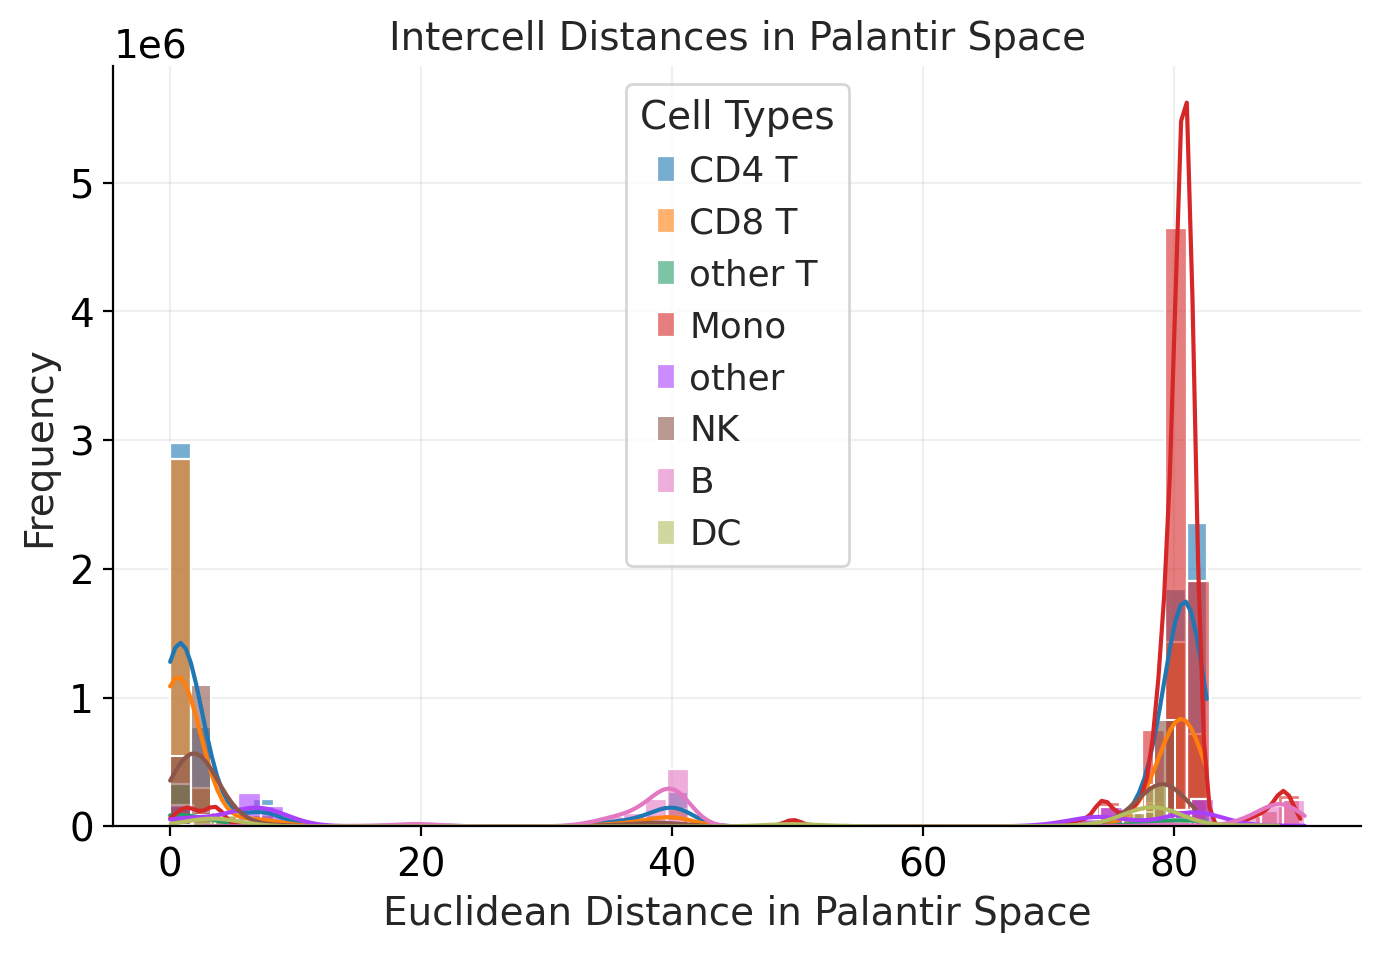

In [72]:
# Визуализация распределений межклеточных расстояний
plt.figure(figsize=(8, 5))
for cell_type, distances_palantir_intercell in intercell_distances_palantir.items():
    sns.histplot(distances_palantir_intercell, label=cell_type, kde=True, bins=50, alpha=0.6)

plt.legend(title="Cell Types")
plt.xlabel("Euclidean Distance in Palantir Space")
plt.ylabel("Frequency")
plt.title("Intercell Distances in Palantir Space")
plt.grid(alpha=0.3)
plt.show()